---

# Unsupervised Machine Learning Approach
## Methodology:  HDBSCAN 
###  Univariate Temperature Data
---

**READ**  -  I've created a python script to allow the user to click the button and then they can either have all of the underyling code shown, OR they can just look at the raw output (charts, plots, whatever).  
As you know, sometimes these notebooks contain a fair amount of code... and sometimes folks just want the _results_... here is an [example](https://nbviewer.jupyter.org/urls/gist.github.com/masnick/d6a1af14812c0c4b3314/raw/f7a5abfb6475e683a90b4ac3491d134ef604e460/test.ipynb)

Code defaults to NOT showing any code, so click the toggle button to view the show the underlying code...

In [1]:
# %load toggle.py
# allows code to be hidden, unhidden on jupyter notebook
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide All Notebook Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show All Notebook Code"></form>''')

<br>

<!-- @article{McInnes2017,
  doi = {10.21105/joss.00205},
  url = {https://doi.org/10.21105%2Fjoss.00205},
  year  = {2017},
  month = {mar},
  publisher = {The Open Journal},
  volume = {2},
  number = {11},
  author = {Leland McInnes and John Healy and Steve Astels},
  title = {hdbscan: Hierarchical density based clustering},
  journal = {The Journal of Open Source Software}
} -->

```Import standard python libraries```

In [2]:
import warnings
warnings.filterwarnings("ignore")
# import matplotlib.cbook
# warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import pickle
import datetime
import multiprocessing as mp
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('dark_background')
# default start, but later you can change if you desire 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [27]:
import sklearn.datasets as data
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
import hdbscan

It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters

```Change directories to read in file```

In [5]:
%cd D:\ABSOLUTELY_CRITICAL_BACKUP_FOLDER_LOCATION\

D:\ABSOLUTELY_CRITICAL_BACKUP_FOLDER_LOCATION


```Read in data (parquet saved and exported file from previous notebook```

In [6]:
# tsys01 sensor temp values
import fastparquet
pf = pd.read_parquet('tsys.parquet', engine='fastparquet')

```Convert temperature variable from C to F```

In [7]:
# F = C×(9/5)+32
pf['value_hrf'] = pf['value_hrf'].apply(lambda x: (9/5)*x + 32)

In [8]:
pf.head(10)

,sensor,parameter,value_hrf
timestamp,,,
2019-01-01 00:00:03,tsys01,temperature,40.640
2019-01-01 00:00:28,tsys01,temperature,40.496
2019-01-01 00:00:53,tsys01,temperature,40.406
2019-01-01 00:01:18,tsys01,temperature,40.424
2019-01-01 00:01:43,tsys01,temperature,40.478
2019-01-01 00:02:08,tsys01,temperature,40.424
2019-01-01 00:02:33,tsys01,temperature,40.334
2019-01-01 00:02:58,tsys01,temperature,40.496
2019-01-01 00:03:23,tsys01,temperature,40.424


In [9]:
pf.tail(10)

,sensor,parameter,value_hrf
timestamp,,,
2019-02-28 23:56:10,tsys01,temperature,31.766
2019-02-28 23:56:35,tsys01,temperature,31.946
2019-02-28 23:57:00,tsys01,temperature,32.018
2019-02-28 23:57:25,tsys01,temperature,31.820
2019-02-28 23:57:50,tsys01,temperature,31.784
2019-02-28 23:58:15,tsys01,temperature,31.946
2019-02-28 23:58:40,tsys01,temperature,32.270
2019-02-28 23:59:05,tsys01,temperature,32.144
2019-02-28 23:59:30,tsys01,temperature,32.090


In [10]:
print('\nNumber of rows of data ........', f'{len(pf):,}')


Number of rows of data ........ 203,481


In [11]:
# date range
print('\nStart .....', pf.head(1).index[0])
print('\nEnd .......', pf.tail(1).index[0])


Start ..... 2019-01-01 00:00:03

End ....... 2019-02-28 23:59:55


In [12]:
tsys = pf.copy()
# look at notebook 201, we filtered all the way to 
# tsys01 level, my imported data (parquet) already
# assumes that was all done, so for clarity, renaming
# pf to the tsys equivalent from 201...

In [13]:
tsys.head(10)

,sensor,parameter,value_hrf
timestamp,,,
2019-01-01 00:00:03,tsys01,temperature,40.640
2019-01-01 00:00:28,tsys01,temperature,40.496
2019-01-01 00:00:53,tsys01,temperature,40.406
2019-01-01 00:01:18,tsys01,temperature,40.424
2019-01-01 00:01:43,tsys01,temperature,40.478
2019-01-01 00:02:08,tsys01,temperature,40.424
2019-01-01 00:02:33,tsys01,temperature,40.334
2019-01-01 00:02:58,tsys01,temperature,40.496
2019-01-01 00:03:23,tsys01,temperature,40.424


In [14]:
tsys.tail(10)

,sensor,parameter,value_hrf
timestamp,,,
2019-02-28 23:56:10,tsys01,temperature,31.766
2019-02-28 23:56:35,tsys01,temperature,31.946
2019-02-28 23:57:00,tsys01,temperature,32.018
2019-02-28 23:57:25,tsys01,temperature,31.820
2019-02-28 23:57:50,tsys01,temperature,31.784
2019-02-28 23:58:15,tsys01,temperature,31.946
2019-02-28 23:58:40,tsys01,temperature,32.270
2019-02-28 23:59:05,tsys01,temperature,32.144
2019-02-28 23:59:30,tsys01,temperature,32.090


<br>

<br>

# A) Initial Examination into HDBSCAN:

In [15]:
# after this, will grab a much larger dataset

In [16]:
tsys.dtypes

sensor       category
parameter    category
value_hrf     float64
dtype: object

In [17]:
len(tsys)

203481

In [18]:
X = tsys['value_hrf'].copy()
# X[:10]
# X.values[:10]
# Utilize standard scaler 
X = StandardScaler().fit_transform(X.values.reshape(-1,1))

In [19]:

clusterer= hdbscan.HDBSCAN(min_cluster_size=25, 
                           prediction_data=True, 
                           gen_min_span_tree=True)
clusterer.fit(X)


HDBSCAN(gen_min_span_tree=True, min_cluster_size=25, prediction_data=True)

```printing out relevant data:```

In [20]:
clusterer.get_params()

{'algorithm': 'best',
 'allow_single_cluster': False,
 'alpha': 1.0,
 'approx_min_span_tree': True,
 'cluster_selection_epsilon': 0.0,
 'cluster_selection_method': 'eom',
 'core_dist_n_jobs': 4,
 'gen_min_span_tree': True,
 'leaf_size': 40,
 'match_reference_implementation': False,
 'memory': Memory(location=None),
 'metric': 'euclidean',
 'min_cluster_size': 25,
 'min_samples': None,
 'p': None,
 'prediction_data': True}


HDBSCAN is noise aware – it has a notion of data samples that are not assigned to any cluster. (handled by assigning these samples the label -1)

The hdbscan library implements soft clustering, where each data point is assigned a cluster membership score ranging from 0.0 to 1.0. 

A score of 0.0 represents a sample that is not in the cluster at all (all noise points will get this score) while a score of 1.0 represents a sample that is at the heart of the cluster (note that this is not the spatial centroid notion of core). You can access these scores via the probabilities_ attribute.


```python
 hdbscan_methods = ['algorithm',
 'allow_single_cluster',
 'alpha',
 'approx_min_span_tree',
 'cluster_persistence_',
 'cluster_selection_epsilon',
 'cluster_selection_method',
 'condensed_tree_',
 'core_dist_n_jobs',
 'exemplars_',
 'fit',
 'fit_predict',
 'gen_min_span_tree',
 'generate_prediction_data',
 'get_params',
 'labels_',
 'leaf_size',
 'match_reference_implementation',
 'memory',
 'metric',
 'min_cluster_size',
 'min_samples',
 'minimum_spanning_tree_',
 'outlier_scores_',
 'p',
 'prediction_data',
 'prediction_data_',
 'probabilities_',
 'relative_validity_',
 'set_params',
 'single_linkage_tree_',
 'weighted_cluster_centroid',
 'weighted_cluster_medoid']
    ```
    

```

hdbscan.dist_metrics.METRIC_MAPPING (output):
---------------------------------------------
braycurtis hdbscan.dist_metrics.BrayCurtisDistance
canberra hdbscan.dist_metrics.CanberraDistance
chebyshev hdbscan.dist_metrics.ChebyshevDistance
cityblock hdbscan.dist_metrics.ManhattanDistance
dice hdbscan.dist_metrics.DiceDistance
euclidean hdbscan.dist_metrics.EuclideanDistance
hamming hdbscan.dist_metrics.HammingDistance
haversine hdbscan.dist_metrics.HaversineDistance
infinity hdbscan.dist_metrics.ChebyshevDistance
jaccard hdbscan.dist_metrics.JaccardDistance
kulsinski hdbscan.dist_metrics.KulsinskiDistance
l1 hdbscan.dist_metrics.ManhattanDistance
l2 hdbscan.dist_metrics.EuclideanDistance
mahalanobis hdbscan.dist_metrics.MahalanobisDistance
manhattan hdbscan.dist_metrics.ManhattanDistance
matching hdbscan.dist_metrics.MatchingDistance
minkowski hdbscan.dist_metrics.MinkowskiDistance
p hdbscan.dist_metrics.MinkowskiDistance
pyfunc hdbscan.dist_metrics.PyFuncDistance
rogerstanimoto hdbscan.dist_metrics.RogersTanimotoDistance
russellrao hdbscan.dist_metrics.RussellRaoDistance
seuclidean hdbscan.dist_metrics.SEuclideanDistance
sokalmichener hdbscan.dist_metrics.SokalMichenerDistance
sokalsneath hdbscan.dist_metrics.SokalSneathDistance
wminkowski hdbscan.dist_metrics.WMinkowskiDistance
```

In [21]:
for item in clusterer.get_params().items(): print(item[0], '...............', item[1])  

algorithm ............... best
allow_single_cluster ............... False
alpha ............... 1.0
approx_min_span_tree ............... True
cluster_selection_epsilon ............... 0.0
cluster_selection_method ............... eom
core_dist_n_jobs ............... 4
gen_min_span_tree ............... True
leaf_size ............... 40
match_reference_implementation ............... False
memory ............... Memory(location=None)
metric ............... euclidean
min_cluster_size ............... 25
min_samples ............... None
p ............... None
prediction_data ............... True


---

In [36]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.5,
                                      node_size=70,
                                      edge_linewidth=1); 

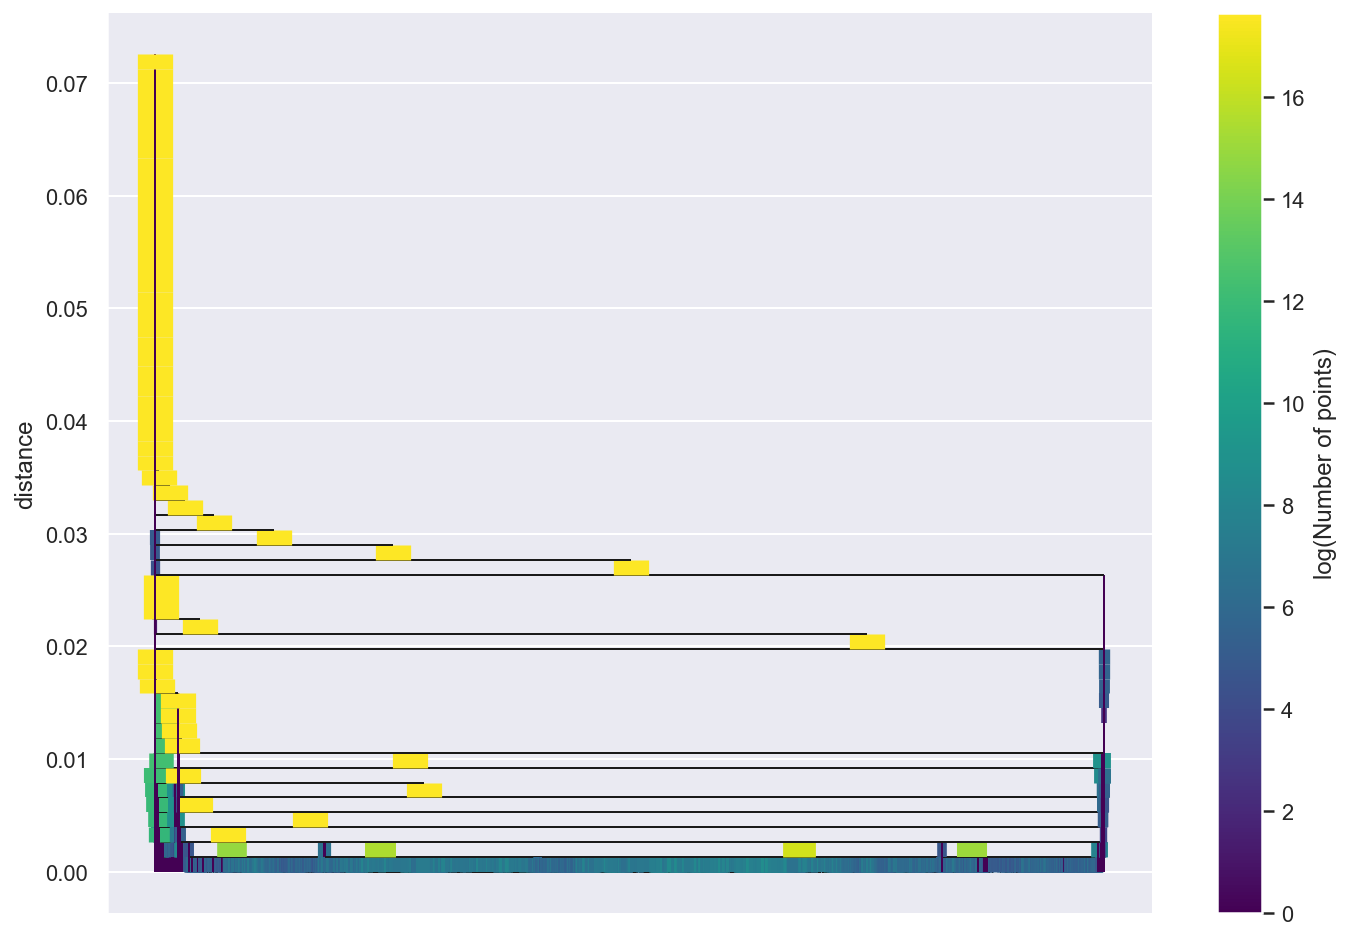

In [37]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True); 

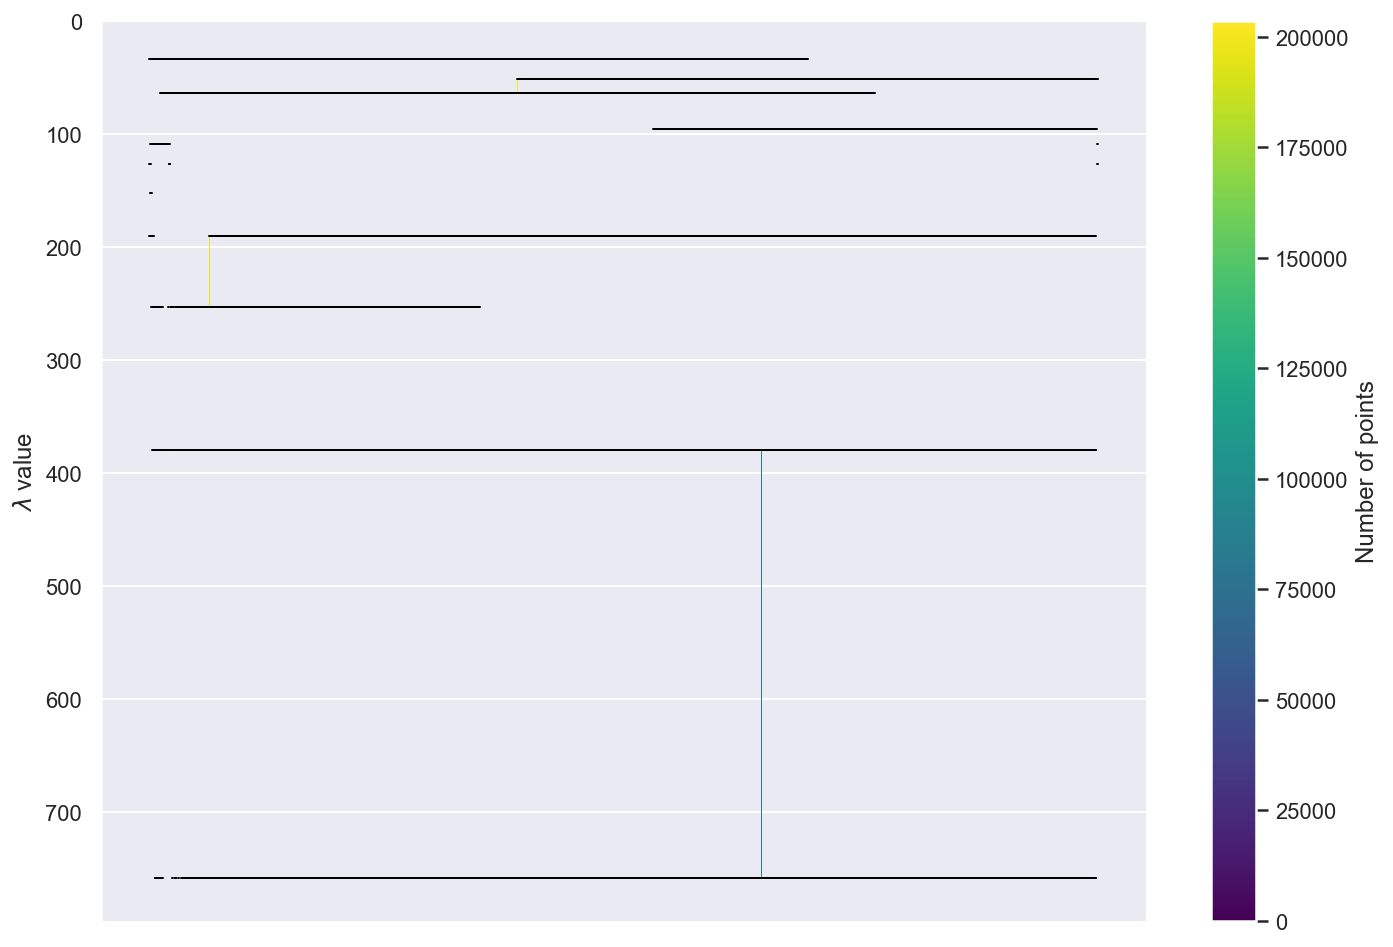

In [38]:
clusterer.condensed_tree_.plot(); 

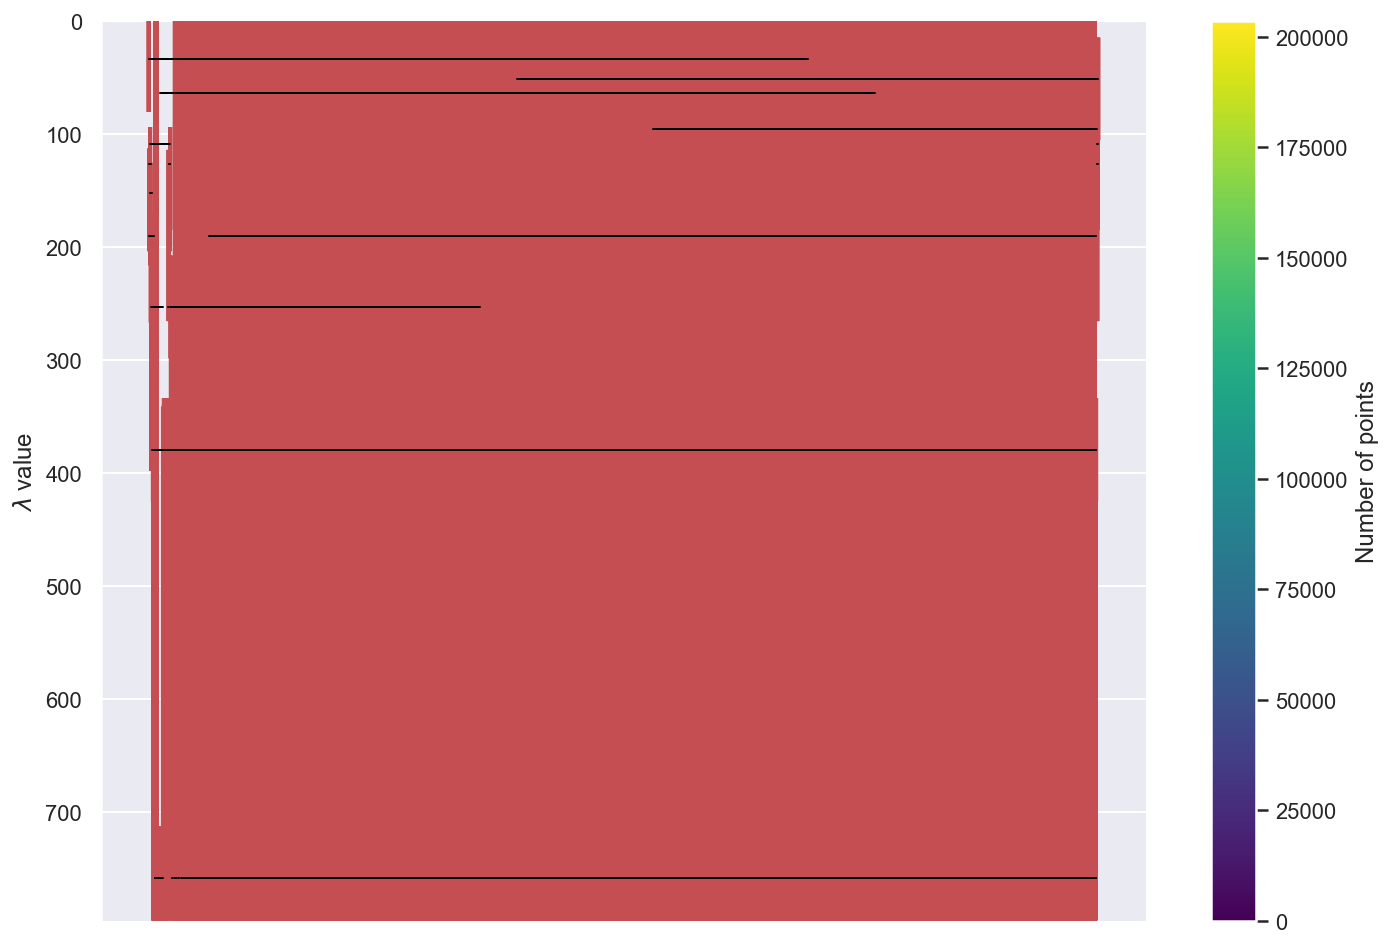

In [39]:
clusterer.condensed_tree_.plot(select_clusters=True, 
                               selection_palette=sns.color_palette()); 

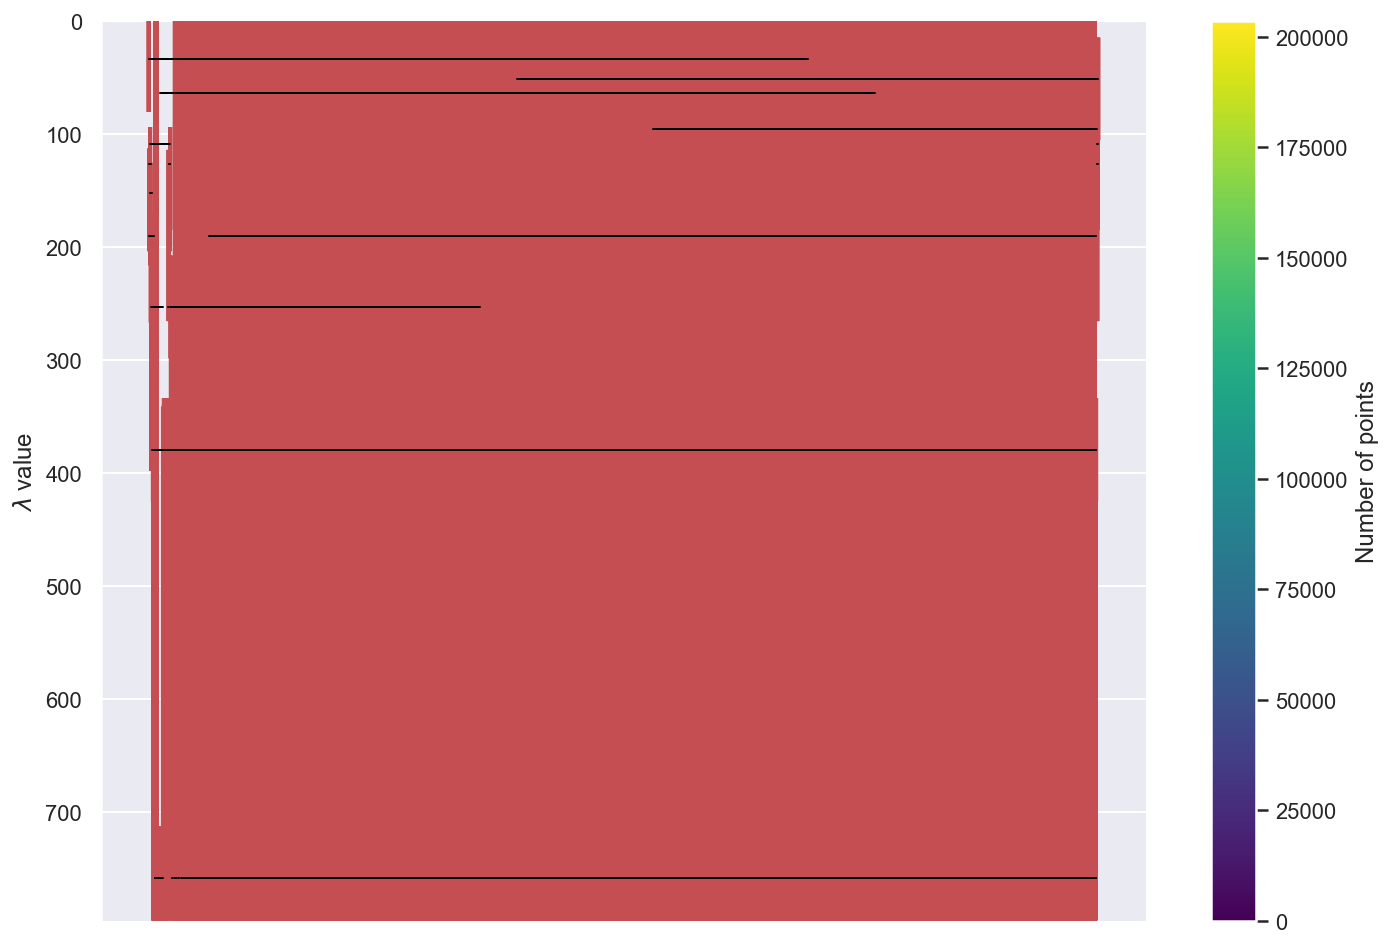

In [45]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8)); 

In [40]:
print(clusterer.probabilities_)

[1. 1. 1. ... 1. 1. 1.]


In [46]:
import networkx as nx

In [47]:
clusterer.condensed_tree_.to_networkx()

In [48]:
g = clusterer.condensed_tree_.to_networkx()
g.number_of_nodes()

209714

In [49]:
clusterer.condensed_tree_.to_pandas().head()


,parent,child,lambda_val,child_size
0,203481,16806,13.785093,1
1,203481,16807,14.040378,1
2,203481,16805,15.795404,1
3,203481,16818,19.440491,1
4,203481,16811,21.060567,1


In [50]:
tree = clusterer.condensed_tree_.to_pandas()
cluster_tree = tree[tree.child_size > 1]

In [57]:
tree[:40]

,parent,child,lambda_val,child_size
0,203481,16806,13.785093,1
1,203481,16807,14.040378,1
2,203481,16805,15.795404,1
3,203481,16818,19.440491,1
4,203481,16811,21.060567,1
5,203481,16803,22.299451,1
6,203481,16825,22.299451,1
7,203481,16826,23.693059,1
8,203481,16812,26.144113,1
9,203481,16804,27.077851,1


In [58]:
cluster_tree[:100]

,parent,child,lambda_val,child_size
20,203481,203482,32.964350,37
21,203481,203483,32.964350,203424
74,203483,203484,50.545253,203357
75,203483,203485,50.545253,52
107,203484,203486,63.182369,4985
108,203484,203487,63.182369,198356
268,203487,203488,94.772800,197803
269,203487,203489,94.772800,496
313,203489,203490,108.312141,400
314,203489,203491,108.312141,82


In [55]:
clusterer.condensed_tree_.to_numpy()

array([(203481, 16806,  13.78509278, 1), (203481, 16807,  14.04037769, 1),
       (203481, 16805,  15.79540398, 1), ...,
       (209558, 91773, 758.30896039, 1), (209558, 87819, 758.30896039, 1),
       (209558, 83826, 758.30896039, 1)],
      dtype=[('parent', '<i8'), ('child', '<i8'), ('lambda_val', '<f8'), ('child_size', '<i8')])

---
---

# B) Single Linkage Trees


In [61]:
clusterer.single_linkage_tree_

In [ ]:
clusterer.single_linkage_tree_.plot(); 

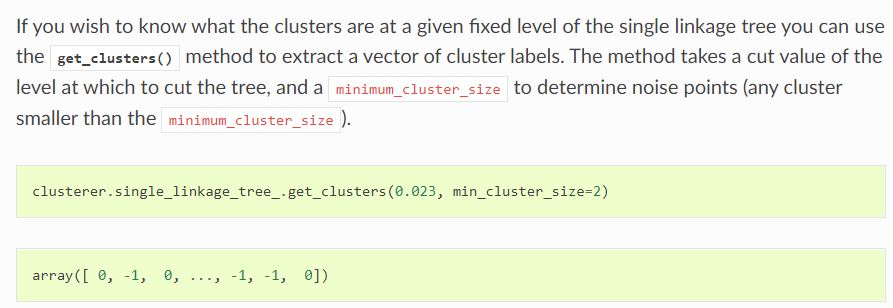

---
---

# B) Anomaly Detection

In [42]:
clusterer.outlier_scores_.value_cpo

array([0., 0., 0., ..., 0., 0., 0.])

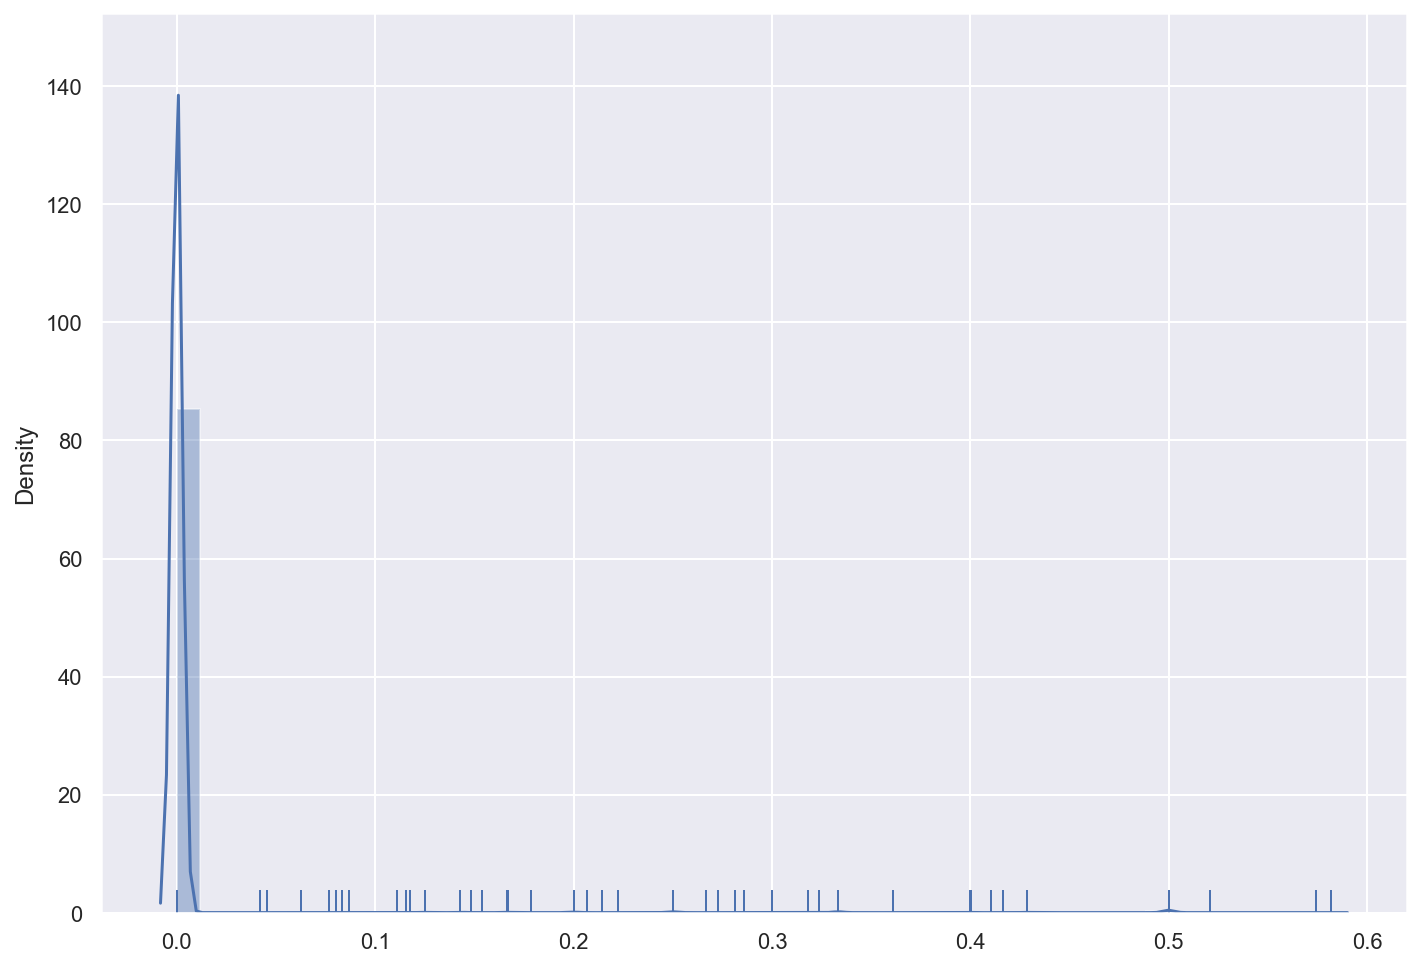

In [51]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True); 

In [ ]:

threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

# We can pull off upper quantiles to detect outliers, which we can then plot.

plt.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)


---
---

```-- ITERATION 1 --
       Plotting the clusters that DBSCAN identified, with our base eps and min_samples hyperparameters:```